In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `Logit` on Orders - A warm-up challenge (~1h)

## Select features

🎯 Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

 

In [44]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

👉 Import your dataset:

In [33]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

👉 Select in a list which features you want to use:

⚠️ Make sure you are not creating data leakage (i.e. selecting features that are derived from the target)

💡 To figure out the impact of `wait_time` and `delay_vs_expected` we need to control for the impact of other features, include in your list all features that may be relevant

In [34]:
features = [
    "wait_time",
    "expected_wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

🕵🏻 Check the `multi-colinearity` of your features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
* Do not forget to standardize your data ! 
    * A `VIF Analysis` is made by regressing a feature vs. the other features...
    * So you want to `remove the effect of scale` so that your features have an equal importance before running any linear regression!
    
    
📚 <a href="https://www.statisticshowto.com/variance-inflation-factor/">Statistics How To - Variance Inflation Factor</a>

📚  <a href="https://online.stat.psu.edu/stat462/node/180/">PennState - Detecting Multicollinearity Using Variance Inflation Factors</a>

⚖️ Standardizing:

In [35]:
orders_sta = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_sta[f] = orders[f].map(lambda x: (x - mu) / sigma)
orders_sta = orders_sta.drop(['order_id','order_status'], axis=1)
orders_sta

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,0.428000,0.955660,-0.387964,0.0,0.0,4.0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,-0.100520,0.499254,-0.585732,0.0,0.0,4.0,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,0.322296,-0.299457,0.600877,1.0,0.0,5.0,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,-0.100520,-0.299457,0.106457,1.0,0.0,5.0,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,1.062224,1.297964,-0.190196,1.0,0.0,5.0,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...
97002,0.428000,0.613355,-0.091311,1.0,0.0,5.0,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
97003,-1.051856,0.042848,-0.981268,0.0,0.0,4.0,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
97004,-1.263264,-0.755863,-0.585732,1.0,0.0,5.0,-0.264595,-0.112544,0.333684,1.964490,0.617630
97005,-0.523336,-1.554574,0.897530,0.0,0.0,2.0,1.601605,-0.112544,1.075186,2.715522,-0.387558


👉 Run your VIF Analysis to analyze the potential multicolinearities:

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

VIF = {}
for i, col in enumerate(orders_sta.columns):
    VIF[col] = round(vif(orders_sta.values, i), 2)

VIF


{'wait_time': 372.76,
 'expected_wait_time': 319.68,
 'delay_vs_expected': 426.1,
 'dim_is_five_star': 4.73,
 'dim_is_one_star': 1.16,
 'review_score': 4.71,
 'number_of_products': 1.38,
 'number_of_sellers': 1.1,
 'price': 1.21,
 'freight_value': 1.68,
 'distance_seller_customer': 1.56}

## Logistic Regressions

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

`Logit 1️⃣`

In [37]:
logit_one = smf.logit(formula = 'dim_is_one_star ~ ' +' + '.join(features), data=orders).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.272979
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 Jul 2022   Pseudo R-squ.:                  0.1467
Time:                        12:10:03   Log-Likelihood:                -26171.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.0808      0.075    -68.123      0.000      -5.227      -4.935
wait_time                   -0.0556      0.024     -2.311      0.021      -0.103      -0.008
expected_wait_time          -0.0147      0.024     -0.612      0.541      -0.062       0.032
delay_vs_expected           -0.0443      0.024     -1.843      0.065      -0.091       0.003
number_of_products           0.4695      0.020     23.776      0.000       0.431       0.508
number_of_sellers            1.5443      0.064     24.069      0.000       1.419       1.670
price                        0.0002   5.44e-05      4.593      0.000       0.000       0.000
freight_value               -0.0007      0.001     -1.163      0.245      -0.002       0.000
distance_seller_customer    -0.0002   2.38e-05     -9.920      0.000      -0.000      -0.000
============================================================================================
"""

`Logit 5️⃣`

In [38]:
logit_five = smf.logit(formula = 'dim_is_five_star ~' +' + '.join(features), data=orders).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.637949
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95863
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 Jul 2022   Pseudo R-squ.:                 0.05640
Time:                        12:10:04   Log-Likelihood:                -61161.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.4385      0.066     36.927      0.000       2.309       2.568
wait_time                    0.0189      0.014      1.356      0.175      -0.008       0.046
expected_wait_time           0.0411      0.014      2.951      0.003       0.014       0.068
delay_vs_expected            0.0549      0.014      3.936      0.000       0.028       0.082
number_of_products          -0.2557      0.016    -16.358      0.000      -0.286      -0.225
number_of_sellers           -1.2096      0.064    -19.009      0.000      -1.334      -1.085
price                     9.251e-05   3.67e-05      2.519      0.012    2.05e-05       0.000
freight_value                0.0002      0.000      0.407      0.684      -0.001       0.001
distance_seller_customer     0.0001   1.46e-05      9.328      0.000       0.000       0.000
============================================================================================
"""

💡 It's time to analyse the results of these two logistic regressions:

- Interpret the partial coefficients in your own words.
- Check their statistical significances with `p-values`
- Do you notice any differences between `logit_one` and `logit_five` in terms of coefficient importances?

In [39]:
# Among the following sentences, store the ones that are true in the list below

a = "delay_vs_expected influences five_star ratings even more than one_star ratings"
b = "wait_time influences five_star ratings even more more than one_star"

your_answer = [ a ]

🧪 __Test your code__

In [40]:
from nbresult import ChallengeResult

result = ChallengeResult('logit',
    answers = your_answer
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0 -- /bin/python3
cachedir: .pytest_cache
rootdir: /home/quantium/labs/lewagon/data-challenges/04-Decision-Science/04-Logistic-Regression/01-Logit/tests
plugins: dash-1.19.0, anyio-3.6.1
collecting ... collected 1 item

test_logit.py::TestLogit::test_question PASSED                           [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/logit.pickle

git commit -m 'Completed logit step'

git push origin master



<details>
    <summary>- <i>Explanations and advanced concepts </i> -</summary>


> _All other thing being equal, the `delay factor` tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries_
    
❗️ However, to be totally rigorous, we have to be **more careful when comparing coefficients from two different models**, because **they might not be based on similar populations**!
    We have 2 sub-populations here: (people who gave 1-stars; and people who gave 5-stars) and they may exhibit intrinsically different behavior patterns. It may well be that "happy-people" (who tends to give 5-stars easily) are less sensitive as "grumpy-people" (who shoot 1-stars like Lucky-Luke), when it comes to "delay", or "price"...

</details>


## Logistic vs. Linear ?

👉 Compare:
- the regression coefficients obtained from the `Logistic Regression `
- with the regression coefficients obtained through a `Linear Regression` 
- on `review_score`, using the same features. 

⚠️ Check that both sets of coefficients  tell  "the same story".

The Linear Regression is used for solving Regression problems whereas Logistic Regression is used for solving the Classification problems.

In [45]:
ols_one = smf.ols(formula = 'dim_is_one_star ~ ' +' + '.join(features), data=orders).fit()
ols_one.summary()
ols_five = smf.ols(formula = 'dim_is_five_star ~ ' +' + '.join(features), data=orders).fit()
ols_five.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dim_is_five_star   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     863.2
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:10:13   Log-Likelihood:                -64594.
No. Observations:               95872   AIC:                         1.292e+05
Df Residuals:                   95863   BIC:                         1.293e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.0297      0.013     76.580      0.000       1.003       1.056
wait_time                    0.0029      0.003      0.924      0.356      -0.003       0.009
expected_wait_time           0.0085      0.003      2.724      0.006       0.002       0.015
delay_vs_expected            0.0108      0.003      3.457      0.001       0.005       0.017
number_of_products          -0.0549      0.003    -16.395      0.000      -0.061      -0.048
number_of_sellers           -0.2588      0.013    -19.950      0.000      -0.284      -0.233
price                     2.198e-05   8.12e-06      2.708      0.007    6.07e-06    3.79e-05
freight_value            -2.321e-05   9.23e-05     -0.251      0.801      -0.000       0.000
distance_seller_customer  2.036e-05   3.21e-06      6.336      0.000    1.41e-05    2.67e-05
==============================================================================
Omnibus:                   527379.568   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11808.515
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                       1.461   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

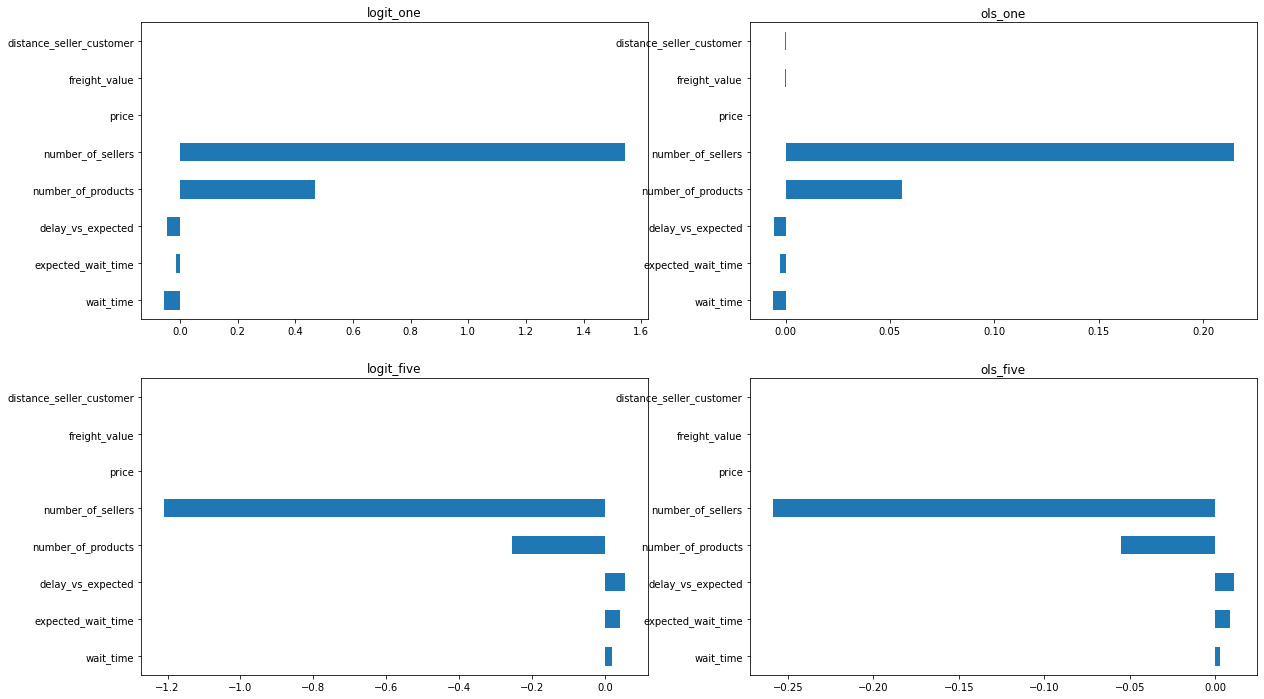

In [48]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
logit_one.params[1:].plot(kind='barh', title = "logit_one")
plt.subplot(2,2,2)
ols_one.params[1:].plot(kind='barh', title = "ols_one")
plt.subplot(2,2,3)
logit_five.params[1:].plot(kind='barh', title = "logit_five")
plt.subplot(2,2,4)
ols_five.params[1:].plot(kind='barh', title = "ols_five");

In [42]:
linear_model = smf.ols(formula = 'review_score ~ ' +' + '.join(features), data=orders).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2083.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:10:07   Log-Likelihood:            -1.5240e+05
No. Observations:               95872   AIC:                         3.048e+05
Df Residuals:                   95863   BIC:                         3.049e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9095      0.034    175.875      0.000       5.844       5.975
wait_time                    0.0201      0.008      2.576      0.010       0.005       0.035
expected_wait_time           0.0219      0.008      2.806      0.005       0.007       0.037
delay_vs_expected            0.0329      0.008      4.208      0.000       0.018       0.048
number_of_products          -0.2404      0.008    -28.713      0.000      -0.257      -0.224
number_of_sellers           -1.0939      0.032    -33.751      0.000      -1.157      -1.030
price                    -1.646e-05   2.03e-05     -0.812      0.417   -5.62e-05    2.33e-05
freight_value            -3.544e-05      0.000     -0.154      0.878      -0.000       0.000
distance_seller_customer     0.0001   8.03e-06     14.656      0.000       0.000       0.000
==============================================================================
Omnibus:                    18642.442   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35855.232
Skew:                          -1.195   Prob(JB):                         0.00
Kurtosis:                       4.806   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

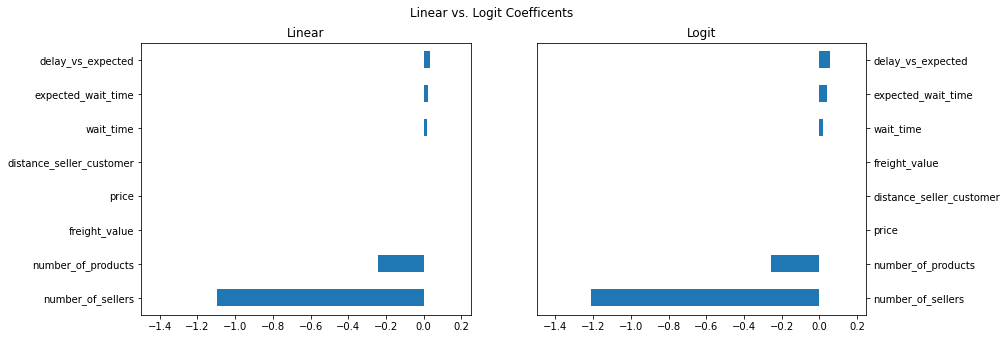

In [55]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficents')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2);

🏁 Congratulations! 

💾 Don't forget to commit and push your `logit.ipynb` notebook !